# KuaiRec Dataset Overview

This notebook provides a comprehensive overview of all data files in the KuaiRec dataset and explains how they fit into complex networks analysis and recommendation systems research.

## About KuaiRec

**KuaiRec** is a fully-observed dataset from Kuaishou (a Chinese short-video sharing platform, similar to TikTok). Unlike typical recommendation datasets where users only interact with a tiny fraction of items (~1%), KuaiRec contains **nearly complete user-item interaction data** (~99.7% coverage).

**Why this matters for complex networks research:**
- **No selection bias**: We can distinguish between "user didn't like it" vs "user was never exposed to it"
- **True preferences**: Study actual user preferences rather than algorithmic filter bubbles
- **Network effects**: Examine how network topology influences content consumption patterns
- **Controlled experiment**: Users were systematically exposed to content, making it ideal for causal inference

**Research Context:**
This dataset allows us to study:
1. **Network structure**: Characterize the social network topology (degree distribution, clustering, path lengths)
2. **Information diffusion**: How content spreads through network edges
3. **Social influence**: Whether node position (centrality) affects viewing behavior
4. **Bipartite networks**: User-video interactions form a bipartite graph structure
5. **Network-based recommendation**: Building models that leverage network topology

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

## Data Files Overview

The KuaiRec dataset consists of 7 main files:

| File | Size | Description |
|------|------|-------------|
| `small_matrix.csv` | 4.7M rows | **Interaction matrix** (subset): User-video watch history |
| `big_matrix.csv` | 12.5M rows | **Interaction matrix** (full): Complete user-video watch history |
| `social_network.csv` | 472 rows | **Social graph**: Friend/follower relationships |
| `user_features.csv` | 7,176 rows | **User attributes**: Demographics, activity levels |
| `item_categories.csv` | 10,728 rows | **Video categories**: Content tags for videos |
| `item_daily_features.csv` | Large | **Video metrics**: Daily engagement statistics per video |
| `kuairec_caption_category.csv` | 10,728 rows | **Video metadata**: Captions, topics, category hierarchy |

---

## 1. Interaction Matrices: `small_matrix.csv` & `big_matrix.csv`

### Purpose
These files contain the **user-video interaction history** forming a **bipartite network** where users and videos are two distinct node sets, and edges represent viewing interactions.

### Difference Between Small and Big
- **small_matrix.csv**: Subset for faster prototyping (~4.7M edges in bipartite graph)
- **big_matrix.csv**: Complete dataset for final analysis (~12.5M edges in bipartite graph)

### Schema
Each row represents a single edge in the bipartite network:

| Column | Type | Description |
|--------|------|-------------|
| `user_id` | int | Node identifier (user partition) |
| `video_id` | int | Node identifier (video partition) |
| `play_duration` | int | Edge weight: how long the user watched (milliseconds) |
| `video_duration` | int | Video node attribute: total length (milliseconds) |
| `time` | datetime | Temporal edge attribute: timestamp of interaction |
| `date` | int | Date in YYYYMMDD format |
| `timestamp` | float | Unix timestamp |
| `watch_ratio` | float | Normalized edge weight: `play_duration / video_duration` |

### Network Interpretation
- **Bipartite graph** G = (U ∪ V, E) where U = users, V = videos
- Each edge e ∈ E connects a user u ∈ U to a video v ∈ V
- Edge weight w(e) = watch_ratio (engagement strength)
- This forms a **weighted bipartite network**

### Key Variable: `watch_ratio`
**This is our primary edge weight for modeling:**
- `watch_ratio = 1.0`: Full engagement (watched entire video)
- `watch_ratio < 1.0`: Partial engagement (skipped/stopped early)
- `watch_ratio > 1.0`: Repeated engagement (rewatched/looped)

### Research Applications
- **Bipartite network analysis**: Project onto user-user or video-video networks
- **Engagement prediction**: What factors predict edge weights?
- **Temporal dynamics**: How does the network evolve over time?
- **Network effects**: Do edges cluster based on social network proximity?

In [2]:
# Load small_matrix for exploration
interactions = pd.read_csv('../data/raw/small_matrix.csv')

print("="*70)
print("INTERACTION MATRIX (small_matrix.csv)")
print("="*70)
print(f"\nBipartite network structure:")
print(f"  Edges (interactions): {len(interactions):,}")
print(f"  User nodes |U|: {interactions['user_id'].nunique():,}")
print(f"  Video nodes |V|: {interactions['video_id'].nunique():,}")
print(f"  Date range: {interactions['date'].min()} to {interactions['date'].max()}")

# Compute degree statistics for bipartite network
user_degree = len(interactions) / interactions['user_id'].nunique()
video_degree = len(interactions) / interactions['video_id'].nunique()

print(f"\nNode degree in bipartite network:")
print(f"  Average user degree <k_user>: {user_degree:.1f} (avg videos watched per user)")
print(f"  Average video degree <k_video>: {video_degree:.1f} (avg views per video)")

print("\n" + "="*70)
print("Sample Data:")
print("="*70)
print(interactions.head(10))

print("\n" + "="*70)
print("Edge Weight (watch_ratio) Statistics:")
print("="*70)
print(interactions['watch_ratio'].describe())

INTERACTION MATRIX (small_matrix.csv)

Bipartite network structure:
  Edges (interactions): 4,676,570
  User nodes |U|: 1,411
  Video nodes |V|: 3,327
  Date range: 20200705.0 to 20200905.0

Node degree in bipartite network:
  Average user degree <k_user>: 3314.4 (avg videos watched per user)
  Average video degree <k_video>: 1405.6 (avg views per video)

Sample Data:
   user_id  video_id  play_duration  video_duration                     time  \
0       14       148           4381            6067  2020-07-05 05:27:48.378   
1       14       183          11635            6100  2020-07-05 05:28:00.057   
2       14      3649          22422           10867  2020-07-05 05:29:09.479   
3       14      5262           4479            7908  2020-07-05 05:30:43.285   
4       14      8234           4602           11000  2020-07-05 05:35:43.459   
5       14      6789           8607           13267  2020-07-05 05:36:00.773   
6       14      1963           8613            9590  2020-07-05 05:36

### Important: Fully Observed Bipartite Network

Notice that **average user degree <k_user> ≈ 3,315** and **|V| ≈ 3,327**. This means nearly every user node has edges to nearly every video node!

**Standard deviation of user degree is only ~7 edges** (out of 3,327 possible), confirming ~99.7% edge coverage in the bipartite network.

**Network implications:**
- We're not studying network **formation** (which edges exist)
- We're studying edge **weights** (strength of engagement)
- This is a **dense bipartite network** (close to complete bipartite graph K_{|U|,|V|})
- Network effects influence **edge weights**, not just **edge existence**

---

## 2. Social Network: `social_network.csv`

### Purpose
Contains the **social network** (graph) showing directed edges representing follower relationships between user nodes.

### Schema

| Column | Type | Description |
|--------|------|-------------|
| `user_id` | int | Node identifier (user) |
| `friend_list` | str | List of adjacent node IDs (edges) - stored as string representation of Python list |

### Network Properties
- **Graph type**: Directed graph (digraph) - edges represent follower/following relationships
- **Coverage**: Only 472 users (out of 1,411 in interactions) have edges in the network
- This means ~67% of users are **isolated nodes** (degree = 0) or their edges weren't recorded
- When merging with interaction data, most rows will have no network features

### Research Applications
- **Network topology analysis**: Study degree distributions, clustering coefficient, average path length
- **Community detection**: Find densely connected subgraphs (communities)
- **Centrality analysis**: Does node centrality correlate with viewing behavior?
- **Diffusion dynamics**: How does content spread through network edges?

### Network Metrics We Can Compute
- **Degree centrality**: Number of edges incident to a node (in-degree + out-degree)
- **Betweenness centrality**: Fraction of shortest paths passing through a node
- **PageRank**: Eigenvector-based centrality measure (importance based on neighbors' importance)
- **Clustering coefficient**: Probability that two neighbors of a node are also neighbors (transitivity)

SOCIAL NETWORK (social_network.csv)

Nodes with edges: 472

Node degree statistics (out-degree):
  Mean degree: 1.42
  Median degree: 1
  Max degree: 5
  Min degree: 1

Total directed edges: 670
Average degree <k>: 1.42

Sample Data:
   user_id friend_list  out_degree
0     3371      [2975]           1
1       24      [2665]           1
2     4402        [38]           1
3     4295      [4694]           1
4     7087      [7117]           1
5     3981      [3937]           1
6      676      [5626]           1
7     6509      [2257]           1
8     5119      [6845]           1
9     2729      [6802]           1


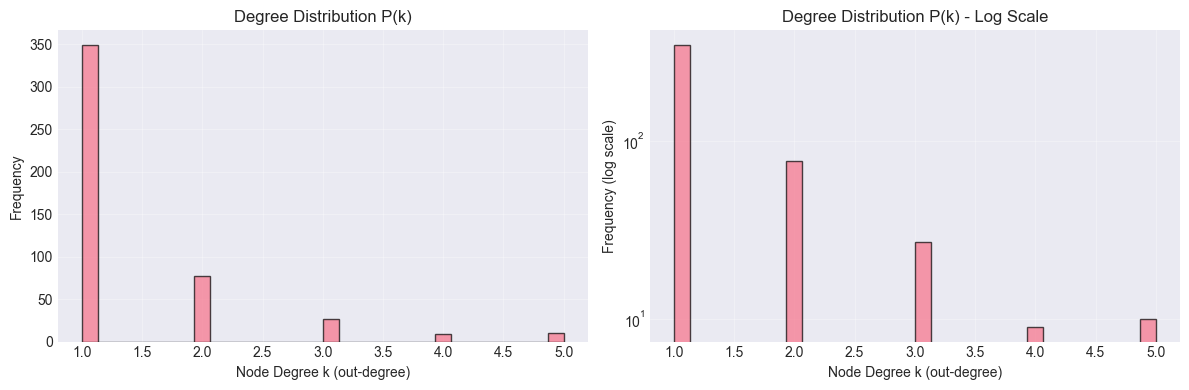

In [3]:
# Load social network
# Note: Some rows have quotes around the friend_list, so we need quoting parameter
social_network = pd.read_csv('../data/raw/social_network.csv', quoting=1)  # QUOTE_ALL or handle quotes

print("="*70)
print("SOCIAL NETWORK (social_network.csv)")
print("="*70)
print(f"\nNodes with edges: {len(social_network):,}")

# Parse adjacency lists to count node degrees
def count_degree(friend_list_str):
    """Count out-degree (number of outgoing edges from this node)"""
    try:
        return len(ast.literal_eval(str(friend_list_str)))
    except:
        return 0

social_network['out_degree'] = social_network['friend_list'].apply(count_degree)

print(f"\nNode degree statistics (out-degree):")
print(f"  Mean degree: {social_network['out_degree'].mean():.2f}")
print(f"  Median degree: {social_network['out_degree'].median():.0f}")
print(f"  Max degree: {social_network['out_degree'].max()}")
print(f"  Min degree: {social_network['out_degree'].min()}")

# Total edges
total_edges = social_network['out_degree'].sum()
print(f"\nTotal directed edges: {total_edges:,}")
print(f"Average degree <k>: {social_network['out_degree'].mean():.2f}")

print("\n" + "="*70)
print("Sample Data:")
print("="*70)
print(social_network.head(10))

# Distribution visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(social_network['out_degree'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Node Degree k (out-degree)')
plt.ylabel('Frequency')
plt.title('Degree Distribution P(k)')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(social_network['out_degree'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Node Degree k (out-degree)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution P(k) - Log Scale')
plt.yscale('log')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. User Features: `user_features.csv`

### Purpose
Contains **node attributes** for user nodes in the network, including demographic and behavioral properties.

### Schema (Key Columns)

| Column | Type | Description |
|--------|------|-------------|
| `user_id` | int | Node identifier |
| `user_active_degree` | str | Activity level category (e.g., 'high_active', 'middle_active') |
| `is_lowactive_period` | int | Whether node is in low activity period (0/1) |
| `is_live_streamer` | int | Whether node creates live content (0/1) |
| `is_video_author` | int | Whether node creates video content (0/1) |
| `follow_user_num` | int | Out-degree: number of users this node follows |
| `fans_user_num` | int | In-degree: number of followers (fans) |
| `friend_user_num` | int | Number of bidirectional edges (mutual follows) |
| `register_days` | int | Node age (days since registration) |
| `onehot_feat0` - `onehot_feat17` | int | Anonymous one-hot encoded node attributes |

### Network Interpretation
- **follow_user_num**: Out-degree in the social network
- **fans_user_num**: In-degree in the social network  
- **friend_user_num**: Number of reciprocal edges (symmetric connections)

### Research Applications
- **Node classification**: Cluster nodes by attribute patterns
- **Degree correlations**: Do active nodes have higher degree?
- **Role analysis**: Content creators vs consumers - different network positions?
- **Attribute homophily**: Do connected nodes share similar attributes?

In [4]:
# Load user features
user_features = pd.read_csv('../data/raw/user_features.csv')

print("="*70)
print("USER FEATURES (user_features.csv)")
print("="*70)
print(f"\nTotal nodes: {len(user_features):,}")
print(f"Total node attributes: {len(user_features.columns)}")

print("\n" + "="*70)
print("Feature Columns:")
print("="*70)
for i, col in enumerate(user_features.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*70)
print("Sample Data:")
print("="*70)
print(user_features.head(10))

print("\n" + "="*70)
print("Key Statistics:")
print("="*70)
print(f"\nContent creators (is_video_author=1): {user_features['is_video_author'].sum():,} ({100*user_features['is_video_author'].mean():.1f}%)")
print(f"Live streamers (is_live_streamer=1): {user_features['is_live_streamer'].sum():,} ({100*user_features['is_live_streamer'].mean():.1f}%)")
print(f"Low activity period: {user_features['is_lowactive_period'].sum():,} ({100*user_features['is_lowactive_period'].mean():.1f}%)")

print(f"\nDegree statistics from node attributes:")
print(user_features[['follow_user_num', 'fans_user_num', 'friend_user_num', 'register_days']].describe())

USER FEATURES (user_features.csv)

Total nodes: 7,176
Total node attributes: 31

Feature Columns:
   1. user_id
   2. user_active_degree
   3. is_lowactive_period
   4. is_live_streamer
   5. is_video_author
   6. follow_user_num
   7. follow_user_num_range
   8. fans_user_num
   9. fans_user_num_range
  10. friend_user_num
  11. friend_user_num_range
  12. register_days
  13. register_days_range
  14. onehot_feat0
  15. onehot_feat1
  16. onehot_feat2
  17. onehot_feat3
  18. onehot_feat4
  19. onehot_feat5
  20. onehot_feat6
  21. onehot_feat7
  22. onehot_feat8
  23. onehot_feat9
  24. onehot_feat10
  25. onehot_feat11
  26. onehot_feat12
  27. onehot_feat13
  28. onehot_feat14
  29. onehot_feat15
  30. onehot_feat16
  31. onehot_feat17

Sample Data:
   user_id user_active_degree  is_lowactive_period  is_live_streamer  \
0        0        high_active                    0                 0   
1        1        full_active                    0                 0   
2        2        fu

## 4. Item Categories: `item_categories.csv`

### Purpose
Contains **content tags/categories** for each video. Simple structure showing which category IDs apply to each video.

### Schema

| Column | Type | Description |
|--------|------|-------------|
| `video_id` | int | Video identifier |
| `feat` | str | List of category IDs (stored as string) |

### Example
- `video_id=1, feat="[27, 9]"` → Video belongs to categories 27 and 9
- `video_id=2, feat="[9]"` → Video only belongs to category 9

### Research Applications
- **Content-based filtering**: Recommend videos with similar categories
- **Genre preferences**: Do users prefer certain content types?
- **Network-content interaction**: Do communities have genre preferences?

In [5]:
# Load item categories
item_categories = pd.read_csv('../data/raw/item_categories.csv')

print("="*70)
print("ITEM CATEGORIES (item_categories.csv)")
print("="*70)
print(f"\nTotal videos: {len(item_categories):,}")

# Parse category lists
item_categories['feat_list'] = item_categories['feat'].apply(lambda x: ast.literal_eval(x))
item_categories['num_categories'] = item_categories['feat_list'].apply(len)
item_categories['primary_category'] = item_categories['feat_list'].apply(lambda x: x[0] if len(x) > 0 else -1)

print(f"\nCategory statistics:")
print(f"  Mean categories per video: {item_categories['num_categories'].mean():.2f}")
print(f"  Max categories per video: {item_categories['num_categories'].max()}")
print(f"  Videos with 1 category: {(item_categories['num_categories'] == 1).sum():,}")
print(f"  Videos with 2+ categories: {(item_categories['num_categories'] > 1).sum():,}")

# Get all unique categories
all_categories = []
for feat_list in item_categories['feat_list']:
    all_categories.extend(feat_list)
unique_categories = len(set(all_categories))

print(f"\nUnique category IDs: {unique_categories}")

print("\n" + "="*70)
print("Sample Data:")
print("="*70)
display(item_categories[['video_id', 'feat', 'num_categories', 'primary_category']].head(15))

# Most common categories
from collections import Counter
category_counts = Counter(all_categories)
print("\n" + "="*70)
print("Most Common Categories:")
print("="*70)
for cat_id, count in category_counts.most_common(10):
    print(f"  Category {cat_id}: {count:,} videos")

ITEM CATEGORIES (item_categories.csv)

Total videos: 10,728

Category statistics:
  Mean categories per video: 1.18
  Max categories per video: 4
  Videos with 1 category: 8,970
  Videos with 2+ categories: 1,758

Unique category IDs: 31

Sample Data:


,video_id,feat,num_categories,primary_category
0,0,[8],1,8
1,1,"[27, 9]",2,27
2,2,[9],1,9
3,3,[26],1,26
4,4,[5],1,5
5,5,[6],1,6
6,6,[19],1,19
7,7,[8],1,8
8,8,[12],1,12
9,9,[11],1,11



Most Common Categories:
  Category 11: 2,027 videos
  Category 28: 1,360 videos
  Category 8: 1,112 videos
  Category 5: 964 videos
  Category 6: 912 videos
  Category 9: 696 videos
  Category 19: 686 videos
  Category 12: 534 videos
  Category 7: 503 videos
  Category 26: 490 videos


## 5. Caption & Category Hierarchy: `kuairec_caption_category.csv`

### Purpose
Provides **detailed metadata** about videos including:
- Human-readable category names (not just IDs)
- Hierarchical category structure (3 levels)
- Video captions/titles
- Topic tags

### Schema (Key Columns)

| Column | Type | Description |
|--------|------|-------------|
| `video_id` | int | Video identifier |
| `manual_cover_text` | str | Cover text/title |
| `caption` | str | Video caption/description |
| `topic_tag` | str | List of topic hashtags |
| `first_level_category_id` | int | Top-level category ID |
| `first_level_category_name` | str | Top-level category name (e.g., "Comedy", "Food") |
| `second_level_category_id` | int | Mid-level category ID |
| `second_level_category_name` | str | Mid-level category name |
| `third_level_category_id` | int | Fine-grained category ID |
| `third_level_category_name` | str | Fine-grained category name |

### Category Hierarchy Example
```
Level 1: "Food" (id=12)
  ├─ Level 2: "Food Daily" (id=292)
  │   └─ Level 3: "Food Sharing" (id=1461)
```

### Research Applications
- **Semantic analysis**: What content types are popular?
- **Cross-category behavior**: Do users watch diverse content?
- **Text features**: Use captions for NLP-based recommendations
- **Topic modeling**: Find latent themes in video content

In [6]:
# Load caption/category data
caption_data = pd.read_csv('../data/raw/kuairec_caption_category.csv')

print("="*70)
print("CAPTION & CATEGORY HIERARCHY (kuairec_caption_category.csv)")
print("="*70)
print(f"\nTotal videos: {len(caption_data):,}")
print(f"Total columns: {len(caption_data.columns)}")

print("\n" + "="*70)
print("Sample Data:")
print("="*70)
display(caption_data.head(10))

# Category analysis
print("\n" + "="*70)
print("First-Level Categories (Main Topics):")
print("="*70)
category_dist = caption_data['first_level_category_name'].value_counts()
for category, count in category_dist.head(15).items():
    print(f"  {category:20s}: {count:,} videos ({100*count/len(caption_data):.1f}%)")

# Visualize category distribution
plt.figure(figsize=(14, 6))
top_categories = category_dist.head(15)
plt.barh(range(len(top_categories)), top_categories.values, alpha=0.7)
plt.yticks(range(len(top_categories)), top_categories.index)
plt.xlabel('Number of Videos')
plt.title('Top 15 First-Level Categories')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Caption analysis
print("\n" + "="*70)
print("Caption Statistics:")
print("="*70)
has_caption = caption_data['caption'].notna() & (caption_data['caption'] != '') & (caption_data['caption'] != 'UNKNOWN')
print(f"Videos with captions: {has_caption.sum():,} ({100*has_caption.mean():.1f}%)")
print(f"Videos without captions: {(~has_caption).sum():,} ({100*(~has_caption).mean():.1f}%)")

ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


## 6. Item Daily Features: `item_daily_features.csv`

### Purpose
Contains **daily engagement metrics** for each video - showing how videos perform over time.

### Schema (Selected Columns)

**Basic Info:**
- `video_id`: Video identifier
- `date`: Date (YYYYMMDD format)
- `author_id`: Creator ID
- `video_duration`: Length in milliseconds

**Engagement Metrics:**
- `show_cnt`: Number of impressions
- `show_user_num`: Unique users shown
- `play_cnt`: Number of plays
- `play_user_num`: Unique users who played
- `play_duration`: Total watch time
- `complete_play_cnt`: Number of complete views
- `valid_play_cnt`: Valid plays (watched >X%)
- `play_progress`: Average watch progress

**Interactions:**
- `like_cnt`: Number of likes
- `comment_cnt`: Number of comments
- `share_cnt`: Number of shares
- `follow_cnt`: Follows gained from video
- `collect_cnt`: Times video was saved/collected

### Research Applications
- **Temporal dynamics**: How do videos gain/lose popularity?
- **Virality prediction**: What makes content go viral?
- **Engagement quality**: Beyond views, what drives interaction?
- **Creator success**: What predicts video performance?

In [ ]:
# Load item daily features (may be large - load sample)
print("="*70)
print("ITEM DAILY FEATURES (item_daily_features.csv)")
print("="*70)
print("\nNote: This is a large file with daily-level video metrics.")
print("Loading first 10,000 rows for exploration...\n")

daily_features = pd.read_csv('../data/raw/item_daily_features.csv', nrows=10000)

print(f"Total columns: {len(daily_features.columns)}")
print(f"Sample size: {len(daily_features):,} rows\n")

print("="*70)
print("Column Names:")
print("="*70)
for i, col in enumerate(daily_features.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*70)
print("Sample Data:")
print("="*70)
display(daily_features[['video_id', 'date', 'play_cnt', 'play_user_num', 
                         'play_duration', 'like_cnt', 'comment_cnt', 'share_cnt']].head(10))

print("\n" + "="*70)
print("Key Metrics Summary:")
print("="*70)
print(daily_features[['play_cnt', 'play_user_num', 'play_duration', 
                       'like_cnt', 'comment_cnt', 'share_cnt']].describe())

## 7. Data Relationships & Integration

### How the Files Connect

```
                    INTERACTIONS (small/big_matrix.csv)
                           │
                           │ Contains: user_id, video_id, watch_ratio
                           │
            ┌──────────────┴───────────────┐
            │                              │
            ▼                              ▼
    USER DIMENSION                  VIDEO DIMENSION
            │                              │
    ┌───────┴────────┐          ┌─────────┴──────────┐
    │                │          │                    │
    ▼                ▼          ▼                    ▼
social_network   user_features  item_categories   item_daily_features
    │                │          │                    │
    │                │          ▼                    │
    │                │     kuairec_caption_category  │
    │                │                               │
    └────────────────┴───────────────────────────────┘
                           │
                           ▼
                  MERGED DATASET FOR ANALYSIS
```

### Typical Merge Strategy

1. **Start with interactions** (small or big matrix)
2. **Add user features** via `user_id`
3. **Add network features** via `user_id` (compute from social_network.csv)
4. **Add video categories** via `video_id`
5. **Add video metadata** via `video_id`
6. **(Optional) Add daily metrics** via `video_id` + `date`

### Example Integration Code

In [ ]:
# Example: Create a merged dataset

print("Creating integrated dataset...\n")

# Start with interactions
merged = interactions.copy()
print(f"1. Starting with interactions: {len(merged):,} rows")

# Add user features
merged = merged.merge(user_features[['user_id', 'follow_user_num', 'fans_user_num', 
                                     'friend_user_num', 'is_video_author', 
                                     'is_live_streamer', 'register_days']], 
                     on='user_id', how='left')
print(f"2. Added user features: {len(merged):,} rows")

# Add video categories
merged = merged.merge(item_categories[['video_id', 'num_categories', 'primary_category']], 
                     on='video_id', how='left')
print(f"3. Added video categories: {len(merged):,} rows")

# Add video metadata
merged = merged.merge(caption_data[['video_id', 'first_level_category_name', 
                                    'second_level_category_name']], 
                     on='video_id', how='left')
print(f"4. Added video metadata: {len(merged):,} rows")

print(f"\nFinal merged dataset: {len(merged):,} rows × {len(merged.columns)} columns")

print("\n" + "="*70)
print("Sample of Integrated Data:")
print("="*70)
display(merged[['user_id', 'video_id', 'watch_ratio', 'follow_user_num', 
                'num_categories', 'first_level_category_name']].head(10))

## Summary

### Dataset Strengths
1. **Fully observed**: ~99.7% coverage eliminates selection bias
2. **Multi-modal**: User features, video content, social network, temporal data
3. **Rich metadata**: Hierarchical categories, captions, engagement metrics
4. **Real-world**: Actual platform data from millions of interactions

### Key Files for Different Research Questions

| Research Question | Primary Files |
|-------------------|---------------|
| What predicts engagement? | `small_matrix.csv`, `user_features.csv`, `item_categories.csv` |
| How do social networks influence behavior? | `social_network.csv`, `small_matrix.csv`, `user_features.csv` |
| What content types are popular? | `item_categories.csv`, `kuairec_caption_category.csv`, `small_matrix.csv` |
| How does content go viral? | `item_daily_features.csv`, `social_network.csv` |
| Can we build better recommenders? | All files |

---

## References

**KuaiRec Dataset:**
- Paper: "KuaiRec: A Fully-observed Dataset and Insights for Evaluating Recommender Systems"
- Authors: Chongming Gao et al.
- Year: 2022
- Platform: Kuaishou (short-video recommendation platform)

**Key Citation:**
```
@inproceedings{gao2022kuairec,
  title={KuaiRec: A Fully-observed Dataset and Insights for Evaluating Recommender Systems},
  author={Gao, Chongming and Li, Shijun and Lei, Wenqiang and Chen, Jiawei and Li, Biao and Jiang, Peng and He, Xiangnan and Mao, Jiaxin and Chua, Tat-Seng},
  booktitle={CIKM},
  year={2022}
}
```